In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [9]:
data = pd.read_csv('data/kc_house_data.csv')

In [10]:
print(data.shape)
data.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [11]:
#drop columns seen as irrelevant
data.drop(columns = ['id','date','view','lat','long'], inplace=True)

In [12]:
#eliminate properties valued at $200000 or less and luxury homes from data set, 
#luxury homes defined as $500,000 and over 
#dropped 10041 rows
data = data[(data.price < 500000) & (data.price > 200000)]

In [13]:
#eliminate properties with 6 or more bedrooms and 4 or more bathrooms which were outliers in the data
#dropped 110 rows
data = data[(data.bedrooms < 6) & (data.bathrooms < 4)]

#eliminate properties with less than a full bathroom (defined as shower, bathtub, toilet, & sink) as judged
#to be undesirable. 
#dropped 48 rows
data = data[(data.bathrooms >= 1)]

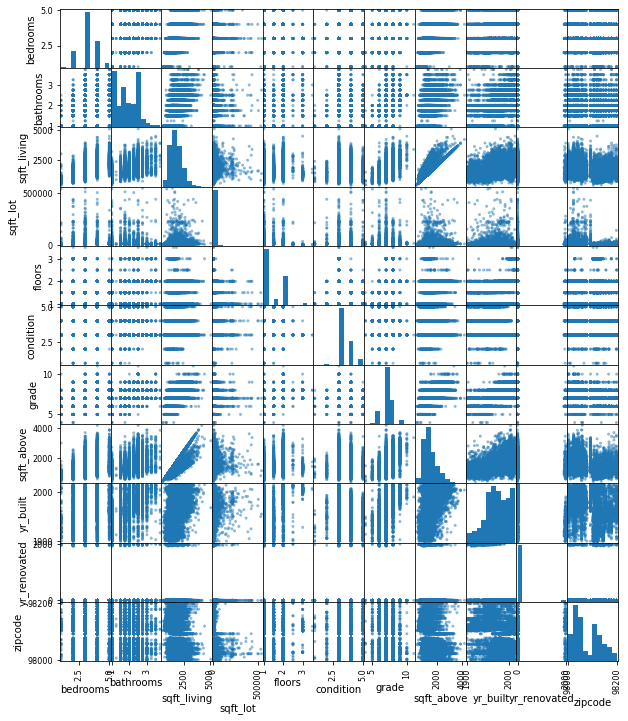

In [14]:
#scatter matrix for data, took out price (target), left out sqft_basement, yr_built, yr_renovated, 
#waterfront, sqft_living15, & sqft_lot15
x_cols = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode']
pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

### bedrooms, bathrooms, floors, condition, and grade appear to be categorical variables
### yr_renovated, sqft_basement and waterfront will also be turned into binary categorical variables indicating presence

In [15]:
#df to look for collinearity in predictors via correlation matrix pairing
data_pred = data.copy()
data_pred.corr()
df=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new 
#column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

#list the pairs with a high correlation, indicating collinearity
df[(df.cc > 0.75) & (df.cc < 1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.801744


### From the correlation matrix, sqft_above and sqft_living have a high correlation indicating collinearity

In [16]:
#change sqft_basement, yr_renovated, and waterfront to binary categorical variables

#change the value ? to string 0
data['sqft_basement'] = data['sqft_basement'].replace(['?'],'0')
#convert datatype of sqft_basement column to float
data = data.astype({'sqft_basement': float})
#create new boolean column for whether property has a basement
data['has_base'] = np.where((data['sqft_basement'] > 0),1,0)
data.head()


#fill NaN values in yr_renovated column with 0
data['yr_renovated'].fillna(0, inplace=True)
#create boolean column for whether a property has been renovated
data['has_renov'] = np.where((data['yr_renovated'] > 0),1,0)
data.head()


#fill NaN values waterfront column with 0 meaning no waterfront view
data['waterfront'].fillna(0, inplace=True)
#convert waterfront to boolean values
data.waterfront = np.where((data['waterfront'] == 1),1,0)

In [17]:
data.floors.value_counts()

1.0    6723
2.0    3526
1.5     804
3.0     313
2.5      30
3.5       2
Name: floors, dtype: int64

In [18]:
data.bathrooms.value_counts()

1.00    2697
2.50    2660
1.75    1914
2.00    1190
2.25    1123
1.50    1001
2.75     380
3.00     234
3.25      96
3.50      90
3.75       9
1.25       4
Name: bathrooms, dtype: int64

In [19]:
#change values in floors columns to prepare for one hot encoding
def floor(value):
    if value == 1:
        return 1
    elif value == 1.5:
        return '1and_half'
    elif value == 2:
        return 2
    elif value == 2.5:
        return '2and_half'
    elif value == 3:
        return 3
    elif value == 3.5:
        return '3and_half'
       
data.floors = data.floors.apply(floor)

In [20]:
#dealing with the bathrooms predictor
#change values in bathrooms column to prepare for one hot encoding
def baths(value):
    if value == 1:
        return 1
    elif value < 2:
        return '1and_quart_plus'
    elif value == 2:
        return 2
    elif value < 3:
        return '2and_quart_plus'
    elif value == 3:
        return 3
    elif value > 3:
        return '3and_quart_plus'
data.bathrooms = data.bathrooms.apply(baths)

In [21]:
#convert datatype of columns bedrooms, bathrooms, floors, condition, and grade to prepare for one hot encoding
convert_dict = {'bedrooms': str, 'bathrooms': str, 'floors': str, 'condition':str, 'grade': str}
data = data.astype(convert_dict)

In [22]:
#create dummy variables for categoricals bedrooms, bathrooms, floors, condition, and grade
bedrooms_dum = pd.get_dummies(data['bedrooms'], prefix='bed', drop_first=True)
bathrooms_dum = pd.get_dummies(data['bathrooms'], prefix='bath', drop_first=True)
floors_dum = pd.get_dummies(data['floors'], prefix='fl', drop_first=True)
condition_dum = pd.get_dummies(data['condition'], prefix='cond', drop_first=True)
grade_dum = pd.get_dummies(data['grade'], prefix='gr', drop_first=True)

In [23]:
#remove orignial columns of dummy variables, add dummy columns
data = data.drop(['bedrooms', 'bathrooms', 'floors', 'condition', 'grade'], axis=1)
data = pd.concat([data, bedrooms_dum, bathrooms_dum, floors_dum, condition_dum, grade_dum], axis=1)
data.head()

,price,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,...,cond_3,cond_4,cond_5,gr_11,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9
0,221900.0,1180,5650,0,1180,0.0,1955,0.0,98178,1340,...,1,0,0,0,0,0,0,1,0,0
6,257500.0,1715,6819,0,1715,0.0,1995,0.0,98003,2238,...,1,0,0,0,0,0,0,1,0,0
7,291850.0,1060,9711,0,1060,0.0,1963,0.0,98198,1650,...,1,0,0,0,0,0,0,1,0,0
8,229500.0,1780,7470,0,1050,730.0,1960,0.0,98146,1780,...,1,0,0,0,0,0,0,1,0,0
9,323000.0,1890,6560,0,1890,0.0,2003,0.0,98038,2390,...,1,0,0,0,0,0,0,1,0,0


array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

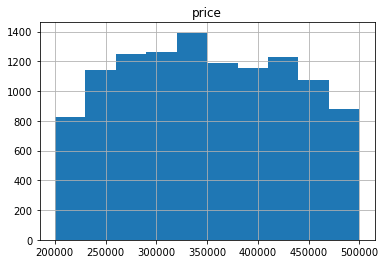

In [24]:
data.hist(column='price')

In [25]:
#dropping features: sqft_above for collinearity with sqft_living, sqft_basement and yr_renovated have binary 
#categoricals for representation, sqftliving15 and sqft_lot15 deemed superfluous
data.drop(['sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
data

,price,sqft_living,sqft_lot,waterfront,yr_built,zipcode,has_base,has_renov,bed_2,bed_3,...,cond_3,cond_4,cond_5,gr_11,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9
0,221900.0,1180,5650,0,1955,98178,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,257500.0,1715,6819,0,1995,98003,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
7,291850.0,1060,9711,0,1963,98198,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,229500.0,1780,7470,0,1960,98146,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,323000.0,1890,6560,0,2003,98038,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21588,429000.0,1490,1126,0,2014,98144,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21591,475000.0,1310,1294,0,2008,98116,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21592,360000.0,1530,1131,0,2009,98103,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21593,400000.0,2310,5813,0,2014,98146,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [26]:
#model with high&low priced outliers eliminated, less than one bathroom eliminated, eliminated outliers 
#with bedrooms > 6 and bathrooms > 4, sqft_basement, yr_renovated, and waterfront to binary categorical 
#variables, dummied bedrooms, bathrooms, floors, condition, and grade, dropped sqftliving15, sqft_lot15, 
#and sqft_above
#train-test split, model with scikit-learn
y = data.price
X = data.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 9118 rows and 32 columns
y_train is a Series with 9118 values
The training mean squared error:  5246459368.455182
The test mean squared error:  5141767653.125333
The training RSME:  72432.44693129718
The test RSME:  71706.12005348869


In [27]:
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     71.92
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:58:40   Log-Likelihood:            -1.1497e+05
No. Observations:                9118   AIC:                         2.300e+05
Df Residuals:                    9085   BIC:                         2.302e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -7.766e+06   1.59e+06     -4.874      0.000   -1.09e+07   -4.64e+06
sqft_living             26.9206      2.260     11.913      0.000      22.491      31.350
sqft_lot                 0.1787      0.029      6.115      0.000       0.121       0.236
waterfront            4.335e+04   2.76e+04      1.570      0.116   -1.08e+04    9.75e+04
yr_built              -834.5535     48.924    -17.058      0.000    -930.456    -738.651
zipcode                 99.4984     15.981      6.226      0.000      68.172     130.825
has_base              1.814e+04   1914.677      9.473      0.000    1.44e+04    2.19e+04
has_renov            -7445.0082   5464.923     -1.362      0.173   -1.82e+04    3267.470
bed_2                -2102.8235   7791.149     -0.270      0.787   -1.74e+04    1.32e+04
bed_3                 -2.41e+04   7819.104     -3.082      0.002   -3.94e+04   -8768.728
bed_4                 -3.11e+04   8068.224     -3.854      0.000   -4.69e+04   -1.53e+04
bed_5                -3.172e+04   8847.667     -3.585      0.000   -4.91e+04   -1.44e+04
bath_1and_quart_plus  7560.8832   2585.956      2.924      0.003    2491.827    1.26e+04
bath_2                9407.4633   3206.527      2.934      0.003    3121.949    1.57e+04
bath_2and_quart_plus  1.788e+04   3400.049      5.259      0.000    1.12e+04    2.45e+04
bath_3                2.312e+04   6429.956      3.596      0.000    1.05e+04    3.57e+04
bath_3and_quart_plus  2.922e+04   7100.776      4.115      0.000    1.53e+04    4.31e+04
fl_1and_half          8648.3341   3230.542      2.677      0.007    2315.745     1.5e+04
fl_2                  1.969e+04   2649.820      7.432      0.000    1.45e+04    2.49e+04
fl_2and_half          4.912e+04   1.47e+04      3.332      0.001    2.02e+04     7.8e+04
fl_3                  5.421e+04   5467.479      9.914      0.000    4.35e+04    6.49e+04
fl_3and_half          1.021e+05   5.15e+04      1.983      0.047    1169.401    2.03e+05
cond_2               -7812.9778   2.45e+04     -0.319      0.750   -5.58e+04    4.02e+04
cond_3                7366.5944   2.31e+04      0.319      0.750   -3.79e+04    5.26e+04
cond_4                3417.1853   2.31e+04      0.148      0.882   -4.18e+04    4.87e+04
cond_5                7246.0124   2.32e+04      0.312      0.755   -3.82e+04    5.27e+04
gr_11                -1.294e+04   7.41e+04     -0.175      0.861   -1.58e+05    1.32e+05
gr_4                 -1.443e+05   3.98e+04     -3.628      0.000   -2.22e+05   -6.63e+04
gr_5                 -1.281e+05    1.7e+04     -7.554      0.000   -1.61e+05   -9.49e+04
gr_6                 -9.599e+04   1.55e+04     -6.207      0.000   -1.26e+05   -6.57e+04
gr_7                 -5.713e+04   1.52e+04     -3.759      0.000   -8.69e+04   -2.73e+04
gr_8                 -2.426e+04   1.51e+04     -1.604    

## The regression model had:
1. Categorical predictors bedrooms, bathrooms, floors, grade and condition one hot encoded
2. Binary categorical predictors waterfront, has_base (from sqft_basement), and has_renov - these predictors indicate the presence or not of variable in each property
3. The R-squared for this model decreased drastically compared to both previous models to 0.208. For the first time in all models ran, the R-squared and Adjusted R-squared values are differnt, the Adjusted R-squared is less than the R-squared by 0.003
4. The intercept's p-value has gone down considerably and confidence level doesn't span 0
5. Categorical bed_2 has high p_value and a confidence level spanning 0
6. Categorical cond_2, cond_3, cond_4, cond_5 have high p-values and a confidence levels spanning 0
7. Categorical gr_8, gr_9, gr_11 have high p-values and confidence levels spanning 0
8. Binary categorical waterfront has high p-value and confidence level spanning 0
9. Binary categorical has_renov has high p-value and confidence level spanning 0

## Next Steps
 - Look for outliers in sqft_living and sqft_lot

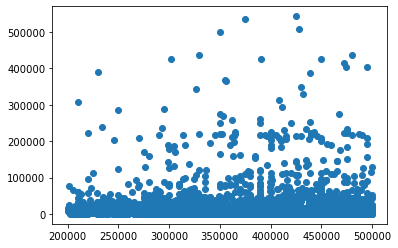

In [28]:
plt.scatter(data['price'], data['sqft_lot']);

In [29]:
data.sqft_lot.describe()

count     11398.000000
mean      11948.404720
std       27441.463041
min         572.000000
25%        5057.000000
50%        7500.000000
75%        9760.000000
max      542322.000000
Name: sqft_lot, dtype: float64

In [30]:
#df with outliers in sqft_living and sqft_lot removed
# 1000 < sqft_living < 10000, 1000 < sqft_lot < 10000
dfOut = data[(data.sqft_living > 1000) & (data.sqft_living <= 3000) & (data.sqft_lot < 10000) & (data.sqft_lot > 1000)]
dfOut

,price,sqft_living,sqft_lot,waterfront,yr_built,zipcode,has_base,has_renov,bed_2,bed_3,...,cond_3,cond_4,cond_5,gr_11,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9
0,221900.0,1180,5650,0,1955,98178,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
6,257500.0,1715,6819,0,1995,98003,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
7,291850.0,1060,9711,0,1963,98198,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
8,229500.0,1780,7470,0,1960,98146,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9,323000.0,1890,6560,0,2003,98038,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21588,429000.0,1490,1126,0,2014,98144,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21591,475000.0,1310,1294,0,2008,98116,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21592,360000.0,1530,1131,0,2009,98103,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
21593,400000.0,2310,5813,0,2014,98146,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [31]:
dfOut.sqft_lot.describe()

count    7499.000000
mean     6268.441259
std      2388.175803
min      1001.000000
25%      4600.000000
50%      6840.000000
75%      8100.000000
max      9998.000000
Name: sqft_lot, dtype: float64

In [32]:
dfOut.sqft_living.describe()

count    7499.000000
mean     1721.471129
std       456.364946
min      1010.000000
25%      1360.000000
50%      1650.000000
75%      2030.000000
max      3000.000000
Name: sqft_living, dtype: float64

In [33]:
#scikit-learn model for df with outliers in sqft_lot and swft_living removed
#train-test split, model with scikit-learn
y = dfOut.price
X = dfOut.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 5999 rows and 32 columns
y_train is a Series with 5999 values
The training mean squared error:  5053662299.835957
The test mean squared error:  5136535187.39174
The training RSME:  71089.11519941683
The test RSME:  71669.62527732192


In [34]:
#statsmodels model for df with outliers in sqft_lot and swft_living removed
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     56.50
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          1.55e-287
Time:                        15:58:41   Log-Likelihood:                -75531.
No. Observations:                5999   AIC:                         1.511e+05
Df Residuals:                    5969   BIC:                         1.513e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -8.779e+06   1.97e+06     -4.449      0.000   -1.26e+07   -4.91e+06
sqft_living             40.2483      3.241     12.418      0.000      33.894      46.602
sqft_lot                -8.1951      0.549    -14.919      0.000      -9.272      -7.118
waterfront           -7.151e-06   1.55e-05     -0.462      0.644   -3.75e-05    2.32e-05
yr_built              -973.5923     58.857    -16.542      0.000   -1088.972    -858.212
zipcode                112.9210     19.777      5.710      0.000      74.150     151.692
has_base              8909.9242   2431.204      3.665      0.000    4143.886    1.37e+04
has_renov            -3319.8043   6790.447     -0.489      0.625   -1.66e+04    9991.926
bed_2                 3.387e+04   1.81e+04      1.874      0.061   -1567.182    6.93e+04
bed_3                  2.23e+04    1.8e+04      1.242      0.214   -1.29e+04    5.75e+04
bed_4                 1.883e+04   1.81e+04      1.041      0.298   -1.66e+04    5.43e+04
bed_5                 1.639e+04   1.86e+04      0.880      0.379   -2.01e+04    5.29e+04
bath_1and_quart_plus  4280.3146   3161.314      1.354      0.176   -1917.005    1.05e+04
bath_2                3653.0802   3843.231      0.951      0.342   -3881.041    1.12e+04
bath_2and_quart_plus  1.246e+04   4142.771      3.009      0.003    4342.491    2.06e+04
bath_3                8974.9426   7252.762      1.237      0.216   -5243.094    2.32e+04
bath_3and_quart_plus  1.277e+04   8406.873      1.519      0.129   -3714.553    2.92e+04
fl_1and_half         -9610.4555   4036.987     -2.381      0.017   -1.75e+04   -1696.503
fl_2                  3920.6218   3581.459      1.095      0.274   -3100.333    1.09e+04
fl_2and_half          1.463e+04   1.98e+04      0.740      0.459   -2.41e+04    5.34e+04
fl_3                  2.946e+04   6958.164      4.233      0.000    1.58e+04    4.31e+04
fl_3and_half          6.834e+04   5.07e+04      1.347      0.178   -3.11e+04    1.68e+05
cond_2               -2.572e+04    5.2e+04     -0.494      0.621   -1.28e+05    7.63e+04
cond_3               -8510.0363   5.06e+04     -0.168      0.866   -1.08e+05    9.06e+04
cond_4               -6972.0860   5.06e+04     -0.138      0.890   -1.06e+05    9.21e+04
cond_5               -5751.1237   5.06e+04     -0.114      0.910   -1.05e+05    9.35e+04
gr_11                 2.012e-10    2.8e-10      0.719      0.472   -3.47e-10     7.5e-10
gr_4                  1.676e-10    2.4e-10      0.699      0.484   -3.02e-10    6.37e-10
gr_5                 -1.719e+05   3.84e+04     -4.477      0.000   -2.47e+05   -9.66e+04
gr_6                 -1.141e+05   3.59e+04     -3.176      0.002   -1.84e+05   -4.37e+04
gr_7                 -7.312e+04   3.57e+04     -2.046      0.041   -1.43e+05   -3062.254
gr_8                  -4.19e+04   3.57e+04     -1.173    

## The regression model had:
1. R-squared increased slightly to 0.218, an increase of 0.016. 
2. yr_built is either insignificant or should be scaled
3. Categorical has_renov has a high p-value and a confidence interval spanning 0
4. zipcode looks overly weighed and should be dummied
5. All bed categoricals have high p-value and confidence intervals spanning 0
6. Categoricals bath_3and_quart_plus, bath_3 and bath_2 have high p-values and confidence intervals spanning 0
7. Categorical fl_1and_half and fl_2and_half have a high p-values and a confidence intervals spanning 0
8. All cond categoricals have high p-value and confidence intervals spanning 0
9. Categorical gr_4, gr_11, gr_8, and gr_9 have high p-values and confidence intervals spanning 0

## Next steps for regression model
 - Log transform and/or scale price, sqft_living, sqft_lot

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>, <AxesSubplot:>]],
      dtype=object)

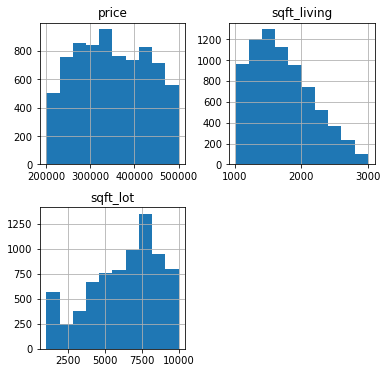

In [35]:
dfOut[['price', 'sqft_living', 'sqft_lot']].hist(figsize=(6,6))

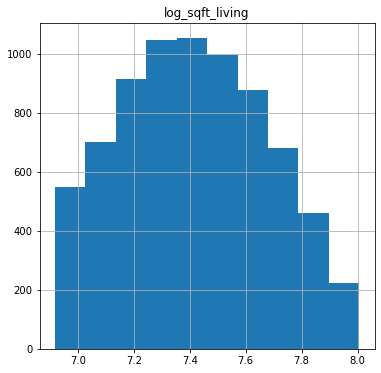

In [36]:
#log transform sqft_living
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(dfOut['sqft_living'])
data_log.hist(figsize=(6,6));

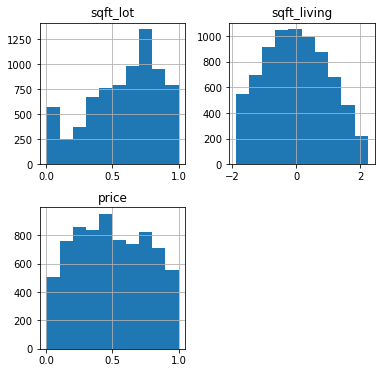

In [37]:
#scale price, sqft_lot and sqftliving_log
sqft_lot = dfOut['sqft_lot']
price = dfOut['price']

scaled_price = (price - min(price)) / (max(price) - min(price))
scaled_sqftlot = (sqft_lot - min(sqft_lot)) / (max(sqft_lot) - min(sqft_lot))
scaled_sqftliving = (data_log - np.mean(data_log)) / np.sqrt(np.var(data_log))

data_scaled = pd.DataFrame([])
data_scaled['sqft_lot'] = scaled_sqftlot
data_scaled['sqft_living'] = scaled_sqftliving
data_scaled['price'] = scaled_price

data_scaled.hist(figsize=(6,6));

In [38]:
#df to add log and scaled sqft_lot and sqft_living
scaled_dfOut = dfOut.copy()

#drop original price, sqft_lot and sqft_living
scaled_dfOut.drop(['price', 'sqft_lot', 'sqft_living'], axis=1, inplace=True)

#concat log and scaled sqft_lot and sqft_living
scaled_dfOut = pd.concat([scaled_dfOut, data_scaled], axis=1)
scaled_dfOut

,waterfront,yr_built,zipcode,has_base,has_renov,bed_2,bed_3,bed_4,bed_5,bath_1and_quart_plus,...,gr_11,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9,sqft_lot,sqft_living,price
0,0,1955,98178,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0.516728,-1.308025,0.071455
6,0,1995,98003,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0.646660,0.117064,0.190324
7,0,1963,98198,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0.968100,-1.716784,0.305019
8,0,1960,98146,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0.719017,0.258850,0.096831
9,0,2003,98038,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0.617873,0.487396,0.409029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21588,0,2014,98144,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.013894,-0.418964,0.762964
21591,0,2008,98116,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.032566,-0.909682,0.916558
21592,0,2009,98103,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0.014449,-0.317994,0.532572
21593,0,2014,98146,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0.534845,1.252239,0.666132


In [39]:
#scikit-learn model for scaled df 
#train-test split, model with scikit-learn
y = scaled_dfOut.price
X = scaled_dfOut.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 5999 rows and 32 columns
y_train is a Series with 5999 values
The training mean squared error:  0.05622262973433413
The test mean squared error:  0.05803544009963738
The training RSME:  0.2371131159053293
The test RSME:  0.24090545884150774


In [40]:
#statsmodels model for scaled df 
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     58.53
Date:                Thu, 08 Jul 2021   Prob (F-statistic):          2.22e-297
Time:                        15:58:43   Log-Likelihood:                 121.66
No. Observations:                5999   AIC:                            -183.3
Df Residuals:                    5969   BIC:                             17.67
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -30.3240      6.564     -4.620      0.000     -43.191     -17.457
waterfront            2.161e-12   3.55e-13      6.089      0.000    1.47e-12    2.86e-12
yr_built                -0.0034      0.000    -17.541      0.000      -0.004      -0.003
zipcode                  0.0004   6.58e-05      5.879      0.000       0.000       0.001
has_base                 0.0250      0.008      3.066      0.002       0.009       0.041
has_renov                0.0018      0.023      0.076      0.940      -0.044       0.048
bed_2                    0.0908      0.057      1.595      0.111      -0.021       0.202
bed_3                    0.0621      0.057      1.099      0.272      -0.049       0.173
bed_4                    0.0485      0.057      0.850      0.395      -0.063       0.160
bed_5                    0.0655      0.059      1.111      0.267      -0.050       0.181
bath_1and_quart_plus     0.0141      0.011      1.330      0.184      -0.007       0.035
bath_2                   0.0098      0.013      0.756      0.450      -0.016       0.035
bath_2and_quart_plus     0.0450      0.014      3.209      0.001       0.017       0.072
bath_3                   0.0322      0.025      1.312      0.189      -0.016       0.080
bath_3and_quart_plus     0.0542      0.028      1.952      0.051      -0.000       0.109
fl_1and_half            -0.0388      0.014     -2.868      0.004      -0.065      -0.012
fl_2                     0.0122      0.012      1.030      0.303      -0.011       0.035
fl_2and_half             0.1005      0.061      1.645      0.100      -0.019       0.220
fl_3                     0.0819      0.023      3.560      0.000       0.037       0.127
fl_3and_half             0.2113      0.169      1.248      0.212      -0.121       0.543
cond_2                  -0.0868      0.144     -0.601      0.548      -0.370       0.196
cond_3                  -0.0205      0.138     -0.149      0.882      -0.291       0.250
cond_4                  -0.0252      0.138     -0.183      0.855      -0.296       0.245
cond_5                  -0.0124      0.138     -0.089      0.929      -0.283       0.259
gr_11                -3.225e-17   1.23e-16     -0.262      0.793   -2.73e-16    2.09e-16
gr_4                 -5.964e-17   3.58e-17     -1.666      0.096    -1.3e-16    1.05e-17
gr_5                    -0.6267      0.130     -4.808      0.000      -0.882      -0.371
gr_6                    -0.4048      0.120     -3.379      0.001      -0.640      -0.170
gr_7                    -0.2617      0.119     -2.196      0.028      -0.495      -0.028
gr_8                    -0.1498      0.119     -1.258      0.209      -0.383       0.084
gr_9                    -0.0691      0.120     -0.574      0.566      -0.305       0.167
sqft_lot                -0.2577      0.016    -15.671    

## The regression model had:
1. R-squared went down to 0.212, a decrease of 0.006
2. waterfront has a high p-value and confidence level spanning 0
3. has_renov has a high p_vaue and confidence level spanning 0
4. All bed categoricals have high p-values and confidence levels spanning 0
5. Categoricals bath_1and_quart_plus, bath_2, and bath_3 have high p-values and confidence levels spanning 0
6. All cond categoricals have high p-values and confidence levels spanning 0
7. Categoricals gr_11, gr_4, gr_8, gr_9 have high p-values and confidence levels spanning 0

## Next steps:
 - One hot code zipcode

In [41]:
#convert zipcode to string, create dummy for zipcode, drop zipcode column and add dummy column
scaled_dfOut = scaled_dfOut.astype({'zipcode': str})
zip_dummy = pd.get_dummies(scaled_dfOut['zipcode'], prefix='zip', drop_first=True)
scaled_dfOut = scaled_dfOut.drop(['zipcode'], axis=1)
scaled_dfOut = pd.concat([scaled_dfOut, zip_dummy], axis=1)
scaled_dfOut.head()

,waterfront,yr_built,has_base,has_renov,bed_2,bed_3,bed_4,bed_5,bath_1and_quart_plus,bath_2,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,1955,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,1995,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1963,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,0,1960,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,2003,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
scaled_dfOut.shape

(7499, 98)

In [43]:
#scikit-learn model for scaled df with dummied zipcode
#train-test split, model with scikit-learn
y = scaled_dfOut.price
X = scaled_dfOut.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

print(f"X_train is a DataFrame with {X_train.shape[0]} rows and {X_train.shape[1]} columns")
print(f"y_train is a Series with {y_train.shape[0]} values")

model = LinearRegression()
model.fit(X_train, y_train)

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('The training mean squared error: ',train_mse)
print('The test mean squared error: ',test_mse)

print('The training RSME: ',train_mse**0.5)
print('The test RSME: ',test_mse**0.5)

X_train is a DataFrame with 5999 rows and 97 columns
y_train is a Series with 5999 values
The training mean squared error:  0.021594720268445198
The test mean squared error:  0.02366291112791493
The training RSME:  0.14695142145772255
The test RSME:  0.15382753696238827


In [44]:
#statsmodels model for scaled df 
#model using statsmodels
features = X_train.copy()
features['price'] = y_train

formula = 'price~' + '+'.join(X_train.columns)
model = ols(formula=formula, data=features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     149.1
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:58:43   Log-Likelihood:                 2991.8
No. Observations:                5999   AIC:                            -5794.
Df Residuals:                    5904   BIC:                            -5157.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6053      0.305      1.982      0.048       0.006       1.204
waterfront           -8.657e-13   3.31e-12     -0.262      0.794   -7.35e-12    5.62e-12
yr_built                -0.0002      0.000     -1.472      0.141      -0.000     6.7e-05
has_base                -0.0145      0.005     -2.698      0.007      -0.025      -0.004
has_renov                0.0456      0.015      3.125      0.002       0.017       0.074
bed_2                    0.0246      0.034      0.723      0.470      -0.042       0.091
bed_3                    0.0252      0.034      0.746      0.456      -0.041       0.091
bed_4                    0.0337      0.034      0.988      0.323      -0.033       0.100
bed_5                    0.0148      0.035      0.419      0.675      -0.055       0.084
bath_1and_quart_plus     0.0045      0.007      0.669      0.504      -0.009       0.018
bath_2                   0.0028      0.008      0.340      0.734      -0.013       0.019
bath_2and_quart_plus     0.0450      0.009      5.053      0.000       0.028       0.063
bath_3                   0.0220      0.015      1.435      0.151      -0.008       0.052
bath_3and_quart_plus     0.0251      0.018      1.403      0.161      -0.010       0.060
fl_1and_half            -0.0022      0.009     -0.253      0.800      -0.019       0.015
fl_2                     0.0009      0.008      0.116      0.908      -0.014       0.016
fl_2and_half             0.0345      0.038      0.911      0.362      -0.040       0.109
fl_3                    -0.0818      0.016     -5.197      0.000      -0.113      -0.051
fl_3and_half             0.3220      0.149      2.160      0.031       0.030       0.614
cond_2                   0.1226      0.112      1.098      0.272      -0.096       0.341
cond_3                   0.1933      0.109      1.781      0.075      -0.019       0.406
cond_4                   0.2195      0.109      2.022      0.043       0.007       0.432
cond_5                   0.2520      0.109      2.318      0.021       0.039       0.465
gr_11                -2.174e-16   1.34e-15     -0.163      0.871   -2.83e-15     2.4e-15
gr_4                  2.467e-15   1.13e-15      2.191      0.028     2.6e-16    4.67e-15
gr_5                    -0.5220      0.092     -5.705      0.000      -0.701      -0.343
gr_6                    -0.3752      0.086     -4.341      0.000      -0.545      -0.206
gr_7                    -0.3148      0.086     -3.659      0.000      -0.483      -0.146
gr_8                    -0.2334      0.086     -2.715      0.007      -0.402      -0.065
gr_9                    -0.0969      0.087     -1.119      0.263      -0.267       0.073
sqft_lot                 0.0517      0.012      4.272      0.000       0.028       0.075
sqft_living              0.0953      0.003     29.461    

## The regression model had:
1. R-squared went up greatly to 0.701, an increase of 0.489
2. waterfront may possibly be insignificant looking at its coefficient
3. All bed categoricals have high p-values and confidence levels spanning 0
4. Categoricals bath_1and_quart_plus and bath_2 have high p-values and confidence levels spanning 0
5. Categoricals fl_2 and fl_2and_half have high p-values and confidence levels spanning 0
6. All cond categoricals have high p-values and confidence levels spanning 0
7. Categorical gr_9 havs a high p-value and a confidence level spanning 0
8. Categoricals zip_98002, zip_98003, zip_98010, zip_98022, zip_98032, and zip_98092 have high p-values and confidence levels spanning 0

In [46]:
scaled_dfOut.columns

Index(['waterfront', 'yr_built', 'has_base', 'has_renov', 'bed_2', 'bed_3',
       'bed_4', 'bed_5', 'bath_1and_quart_plus', 'bath_2',
       'bath_2and_quart_plus', 'bath_3', 'bath_3and_quart_plus',
       'fl_1and_half', 'fl_2', 'fl_2and_half', 'fl_3', 'fl_3and_half',
       'cond_2', 'cond_3', 'cond_4', 'cond_5', 'gr_11', 'gr_4', 'gr_5', 'gr_6',
       'gr_7', 'gr_8', 'gr_9', 'sqft_lot', 'sqft_living', 'price', 'zip_98002',
       'zip_98003', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008',
       'zip_98010', 'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022',
       'zip_98023', 'zip_98024', 'zip_98027', 'zip_98028', 'zip_98029',
       'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
       'zip_98038', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053',
       'zip_98055', 'zip_98056', 'zip_98058', 'zip_98059', 'zip_98065',
       'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 'zip_98077',
       'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_9

In [48]:
zip_list = ['zip_98002','zip_98003', 'zip_98005', 'zip_98006', 'zip_98007', 'zip_98008','zip_98010', 
            'zip_98011', 'zip_98014', 'zip_98019', 'zip_98022','zip_98023', 'zip_98024', 'zip_98027', 
            'zip_98028', 'zip_98029', 'zip_98030', 'zip_98031', 'zip_98032', 'zip_98033', 'zip_98034',
            'zip_98038', 'zip_98042', 'zip_98045', 'zip_98052', 'zip_98053', 'zip_98055', 'zip_98056', 
            'zip_98058', 'zip_98059', 'zip_98065', 'zip_98070', 'zip_98072', 'zip_98074', 'zip_98075', 
            'zip_98077', 'zip_98092', 'zip_98102', 'zip_98103', 'zip_98105', 'zip_98106', 'zip_98107', 
            'zip_98108', 'zip_98109', 'zip_98112', 'zip_98115', 'zip_98116', 'zip_98117', 'zip_98118', 
            'zip_98119', 'zip_98122', 'zip_98125', 'zip_98126', 'zip_98133', 'zip_98136', 'zip_98144',
            'zip_98146', 'zip_98148', 'zip_98155', 'zip_98166', 'zip_98168', 'zip_98177', 'zip_98178', 
            'zip_98188', 'zip_98198', 'zip_98199']
zipcodes = scaled_dfOut.loc[:,zip_list]
zipcodes.head()

,zip_98002,zip_98003,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.053000e-01,3.050000e-01,1.982,0.048,6.000000e-03,1.204000e+00
waterfront,-8.657000e-13,3.310000e-12,-0.262,0.794,-7.350000e-12,5.620000e-12
yr_built,-2.000000e-04,0.000000e+00,-1.472,0.141,-0.000000e+00,6.700000e-05
has_base,-1.450000e-02,5.000000e-03,-2.698,0.007,-2.500000e-02,-4.000000e-03
has_renov,4.560000e-02,1.500000e-02,3.125,0.002,1.700000e-02,7.400000e-02
...,...,...,...,...,...,...
zip_98177,5.001000e-01,2.400000e-02,20.983,0.000,4.530000e-01,5.470000e-01
zip_98178,1.673000e-01,1.900000e-02,8.802,0.000,1.300000e-01,2.050000e-01
zip_98188,1.151000e-01,2.300000e-02,4.967,0.000,7.000000e-02,1.610000e-01
zip_98198,1.156000e-01,1.900000e-02,6.165,0.000,7.900000e-02,1.520000e-01


In [62]:
len(zip_list)

66

In [63]:
98-66

32

In [74]:
codes = df.iloc[32:,1]
codes

zip_98002    0.020
zip_98003    0.018
zip_98005    0.106
zip_98006    0.032
zip_98007    0.030
             ...  
zip_98177    0.024
zip_98178    0.019
zip_98188    0.023
zip_98198    0.019
zip_98199    0.030
Name: std err, Length: 66, dtype: float64

In [83]:
topten = codes.sort_values(ascending=False).head(10)
topten

zip_98005    0.106
zip_98075    0.075
zip_98109    0.069
zip_98077    0.068
zip_98070    0.068
zip_98102    0.063
zip_98014    0.062
zip_98024    0.062
zip_98112    0.053
zip_98119    0.044
Name: std err, dtype: float64

In [84]:
import geopandas

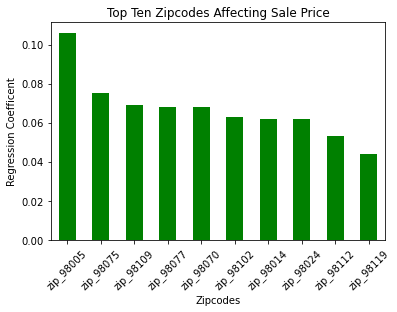

In [94]:
topten.plot.bar(xlabel='Zipcodes', ylabel='Regression Coefficent', 
                title='Top Ten Zipcodes Affecting Sale Price', rot=45, color='green');
